In [26]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import cv2
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import albumentations as albu
import torch
import numpy as np
import smp

In [27]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [28]:
DATA_DIR = '/home/muditj/Desktop/alertwildfire/p1/Computer-Vision-Experiments/data/smoke-object-dataset4'

In [29]:
x_train_dir = os.path.join(DATA_DIR, 'images')    
y_train_dir = os.path.join(DATA_DIR, 'boundingBox')

x_valid_dir = os.path.join(DATA_DIR, 'images')
y_valid_dir = os.path.join(DATA_DIR, 'boundingBox')

x_test_dir = os.path.join(DATA_DIR, 'images')
y_test_dir = os.path.join(DATA_DIR, 'boundingBox')

### Utility Function

In [30]:
def load_mask(json_path):
    #print(json_path)
    mask = np.zeros((1080, 1921), dtype=np.uint8)
    if (json_path == None):
        return mask
    info = json.load(open(json_path, "r"))
    x_points = info[0]['regions'][0]['shape_attributes']['all_points_x']
    y_points = info[0]['regions'][0]['shape_attributes']['all_points_y']
    rr, cc = skimage.draw.polygon(y_points, x_points)
    #print(mask.shape)
    #print(rr, cc)
    mask[rr,cc] = 1
    return mask

In [31]:
from os import path
def find_json(img_path):
    #img_path = os.path.join(root, "images", img_name)
    xml_path = img_path[0:-4] + '.json'
    xml_path = xml_path.replace('images', 'boundingBox')
    if (path.exists(xml_path)):
        return xml_path
    else:
        return None

### Visualization


In [32]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [33]:
CLASSES = ['smoke', 'unlabelled']

### Dataloader 

In [34]:
class Dataset(BaseDataset):

    CLASSES = ['unlabelled', 'smoke']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        #print("\nImage ID : " + str(i))
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = find_json(self.images_fps[i])
        #if mask_path!=None:
            #print("Mask Path : " + mask_path)
        mask = load_mask(mask_path)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']  
        return image, mask
        
    def __len__(self):
        return len(self.ids)

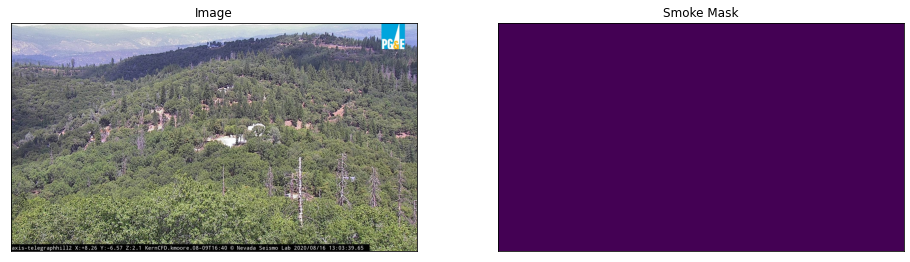

In [35]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['smoke', 'unlabelled'])

image, mask = dataset[475] # get some sample
#print(mask.shape)
visualize(
    image=image, 
    smoke_mask=mask[:,:,0].squeeze(),
)

### Albumentations

In [36]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=640, width=640, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.Resize(height=640, width=640, always_apply=True)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

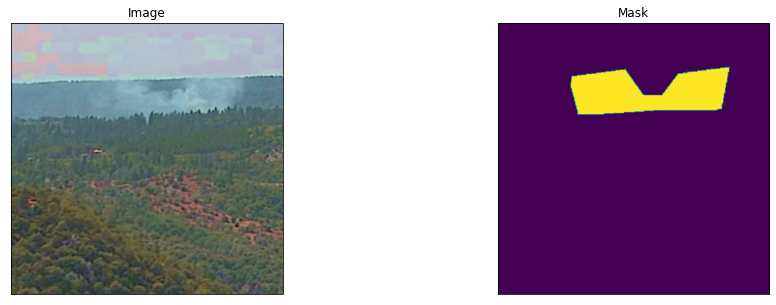

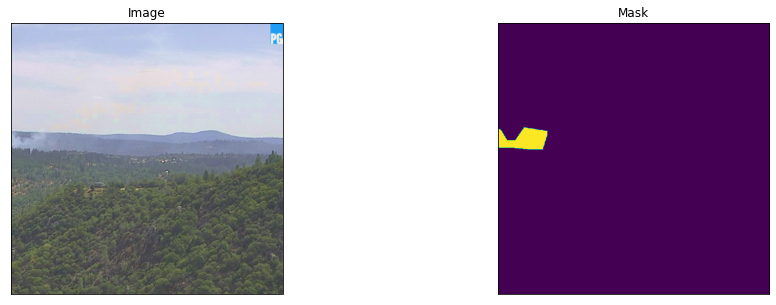

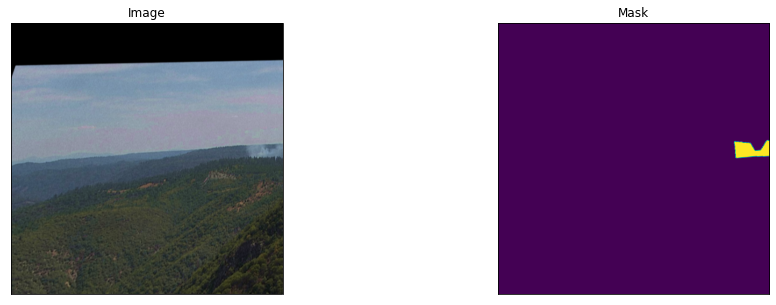

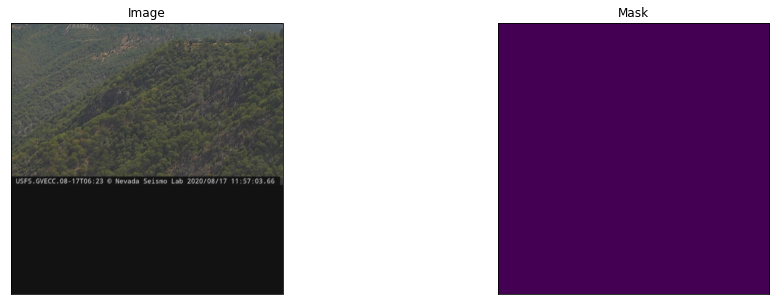

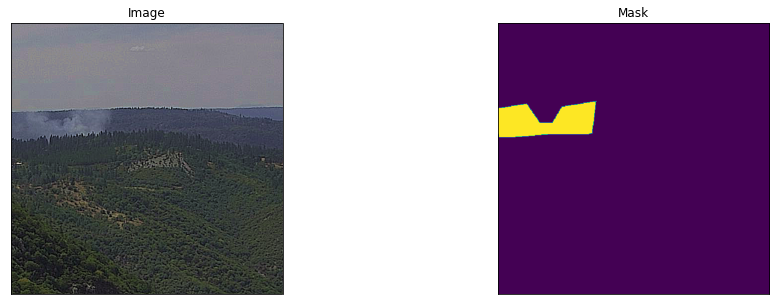

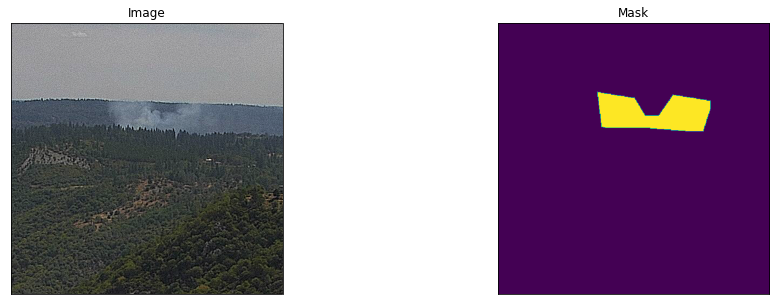

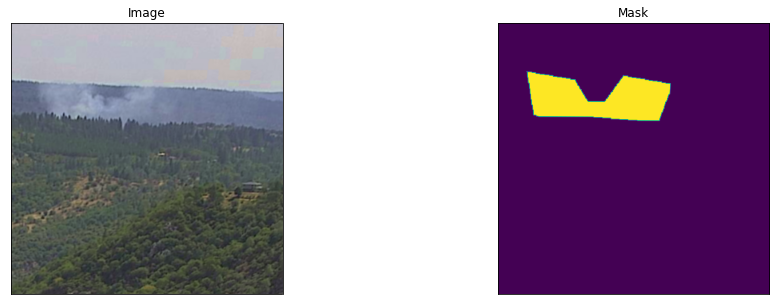

In [37]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['smoke','unlabelled'],
)

# same image with different random transforms
for i in range(3,10):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask[:,:,0].squeeze())

In [38]:
!pip install ipywidgets

In [39]:
#ENCODER = 'efficientnet-b6'
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['smoke', 'unlabelled']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

AttributeError: module 'smp' has no attribute 'FPN'

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(),
    #augmentation = train_transforms,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=8)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.FocalTversky_loss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_efficient_net_b4.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')